# NLP Group Assignment - An Analysis of IMDb Movie Reviews

## Imports & Setup

In [2]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pyLDAvis
import pyLDAvis.gensim_models
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
from nltk import FreqDist, bigrams, trigrams
from nltk.util import ngrams
import torch
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Ensure required NLTK resources are available
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/eliott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/eliott/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eliott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preprocessing

In [4]:
# Data from https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# imdb_df = pd.read_csv('IMDB Dataset.csv')

In [5]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [6]:
#Apply function on review column
# imdb_df['review'] = imdb_df['review'].apply(denoise_text)
# imdb_df['review'] = imdb_df['review'].apply(remove_special_characters)
# imdb_df.to_csv('imdb_reviews_clean.csv', index=False)

In [7]:
# Load the cleaned dataframe
imdb_df = pd.read_csv('imdb_reviews_clean.csv')

In [8]:
# Tokenize and remove stopwords
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words and token not in ['movie', 'film', 'character', 'one', 'even']]
    return tokens

In [9]:
imdb_df['tokens'] = imdb_df['review'].apply(tokenize)

In [10]:
# imdb_df = pd.read_csv('imdb_reviews.csv')

## Sentiment Analysis

### BERT-based model

In [11]:
# Load the tokenizer and model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure model runs on GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [12]:
# Function to predict sentiment
def predict_sentiment(text):
    tokens = tokenizer(
        text, 
        padding="max_length", 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**tokens)
    
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item() + 1  # Sentiment scores are 1-5

    return sentiment

In [ ]:
# Apply sentiment analysis
imdb_df['BERT Sentiment Score'] = imdb_df["review"].astype(str).apply(predict_sentiment)

In [ ]:
# Filter the dataframe
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']

low_score_reviews = imdb_df[
    (imdb_df['BERT Sentiment Score'].isin([1, 2]))
]

# Calculate the proportion
correct_negative_reviews = len(low_score_reviews) / len(negative_reviews)
print(f"Proportion of reviews with BERT score of 1 or 2 and a sentiment of negative: {correct_negative_reviews:.2%} (Correctly classified)")

# Filter the dataframe
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']

high_score_reviews = imdb_df[
    imdb_df['BERT Sentiment Score'].isin([4, 5])
]

# Calculate the proportion
correct_positive_reviews = len(high_score_reviews) / len(positive_reviews)
print(f"Proportion of reviews with BERT score of 4 or 5 and a sentiment of positive: {correct_positive_reviews:.2%} (Correctly classified)")


neutral_score_reviews = imdb_df[
    imdb_df['BERT Sentiment Score'] == 3
]

# Calculate the proportion of neutral score reviews with positive sentiment
neutral_positive_reviews = neutral_score_reviews[neutral_score_reviews['sentiment'] == 'positive']
proportion_neutral_positive = len(neutral_positive_reviews) / len(neutral_score_reviews)
print(f"Proportion of reviews with BERT score of 3 and a sentiment of positive: {proportion_neutral_positive:.2%} (BERT says neutral, but the sentiment is positive)")

# Calculate the proportion of neutral score reviews with negative sentiment
neutral_negative_reviews = neutral_score_reviews[neutral_score_reviews['sentiment'] == 'negative']
proportion_neutral_negative = len(neutral_negative_reviews) / len(neutral_score_reviews)
print(f"Proportion of reviews with BERT score of 3 and a sentiment of negative: {proportion_neutral_negative:.2%} (BERT says neutral, but the sentiment is negative)")

Proportion of reviews with BERT score of 1 or 2 and a sentiment of negative: 95.07% (Correctly classified)
Proportion of reviews with BERT score of 4 or 5 and a sentiment of positive: 82.44% (Correctly classified)
Proportion of reviews with BERT score of 3 and a sentiment of positive: 58.51% (BERT says neutral, but the sentiment is positive)
Proportion of reviews with BERT score of 3 and a sentiment of negative: 41.49% (BERT says neutral, but the sentiment is negative)


### VADER

In [ ]:
nltk.download('vader_lexicon')

# Initializing the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute the compound sentiment score
def compute_sentiment(text):
    sentiment_dict = sia.polarity_scores(text) # Computing sentiment scores and extract the compound score
    return sentiment_dict['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eliott/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Apply function to the 'text' column and creating a new 'sentiment' column
imdb_df['VADER Sentiment Score'] = imdb_df['review'].apply(compute_sentiment)

In [ ]:
imdb_df.to_csv('imdb_reviews_with_sentiment.csv', index=False)

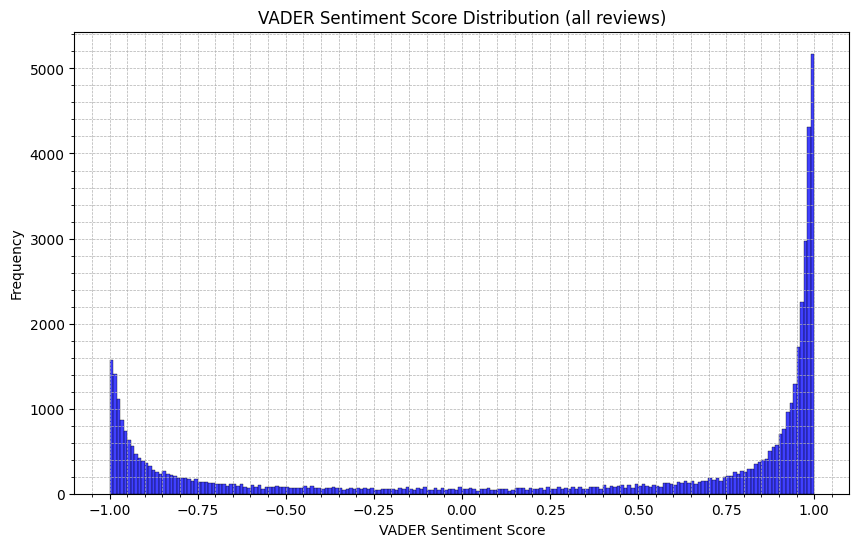

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(imdb_df['VADER Sentiment Score'], bins=200, kde=False, color='blue')
plt.title('VADER Sentiment Score Distribution (all reviews)')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both major and minor gridlines
plt.minorticks_on()  # Enable minor ticks
plt.show()

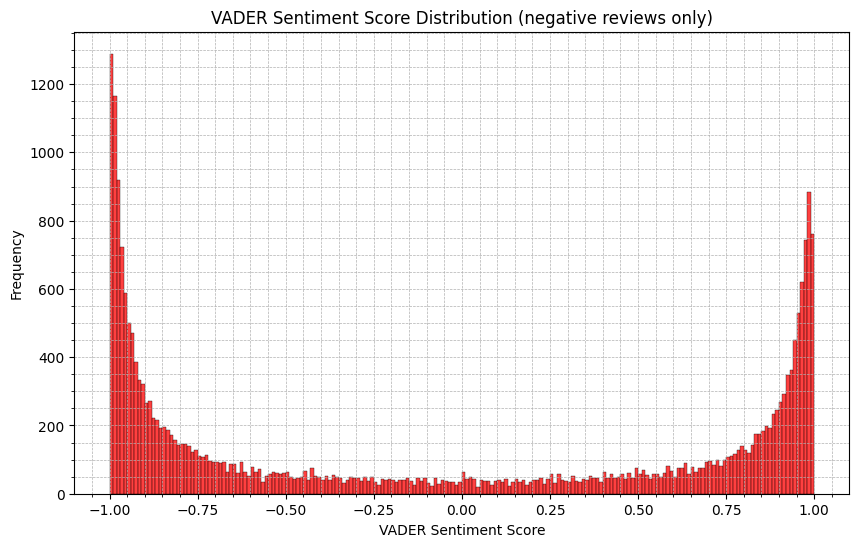

In [ ]:
# Filter the dataframe for negative sentiment reviews
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']

# Plot the VADER Sentiment Score distribution for negative reviews
plt.figure(figsize=(10, 6))
sns.histplot(negative_reviews['VADER Sentiment Score'], bins=200, kde=False, color='red')
plt.title('VADER Sentiment Score Distribution (negative reviews only)')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both major and minor gridlines
plt.minorticks_on()  # Enable minor ticks
plt.show()

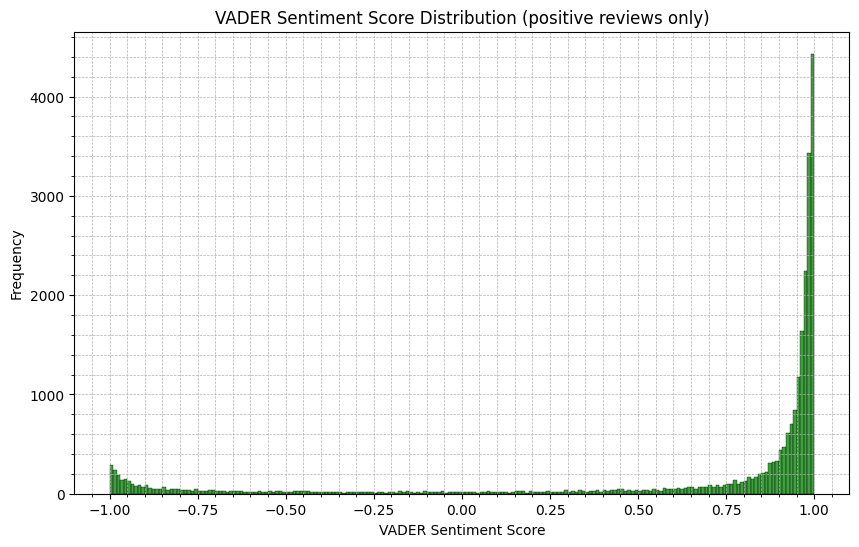

In [ ]:
# Filter the dataframe for negative sentiment reviews
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']

# Plot the VADER Sentiment Score distribution for negative reviews
plt.figure(figsize=(10, 6))
sns.histplot(positive_reviews['VADER Sentiment Score'], bins=200, kde=False, color='green')
plt.title('VADER Sentiment Score Distribution (positive reviews only)')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both major and minor gridlines
plt.minorticks_on()  # Enable minor ticks
plt.show()

## Frequency Analysis

In [ ]:
# Flatten the list of lists into a single list of words
words = [token for sublist in imdb_df['tokens'] for token in sublist]

### Single terms

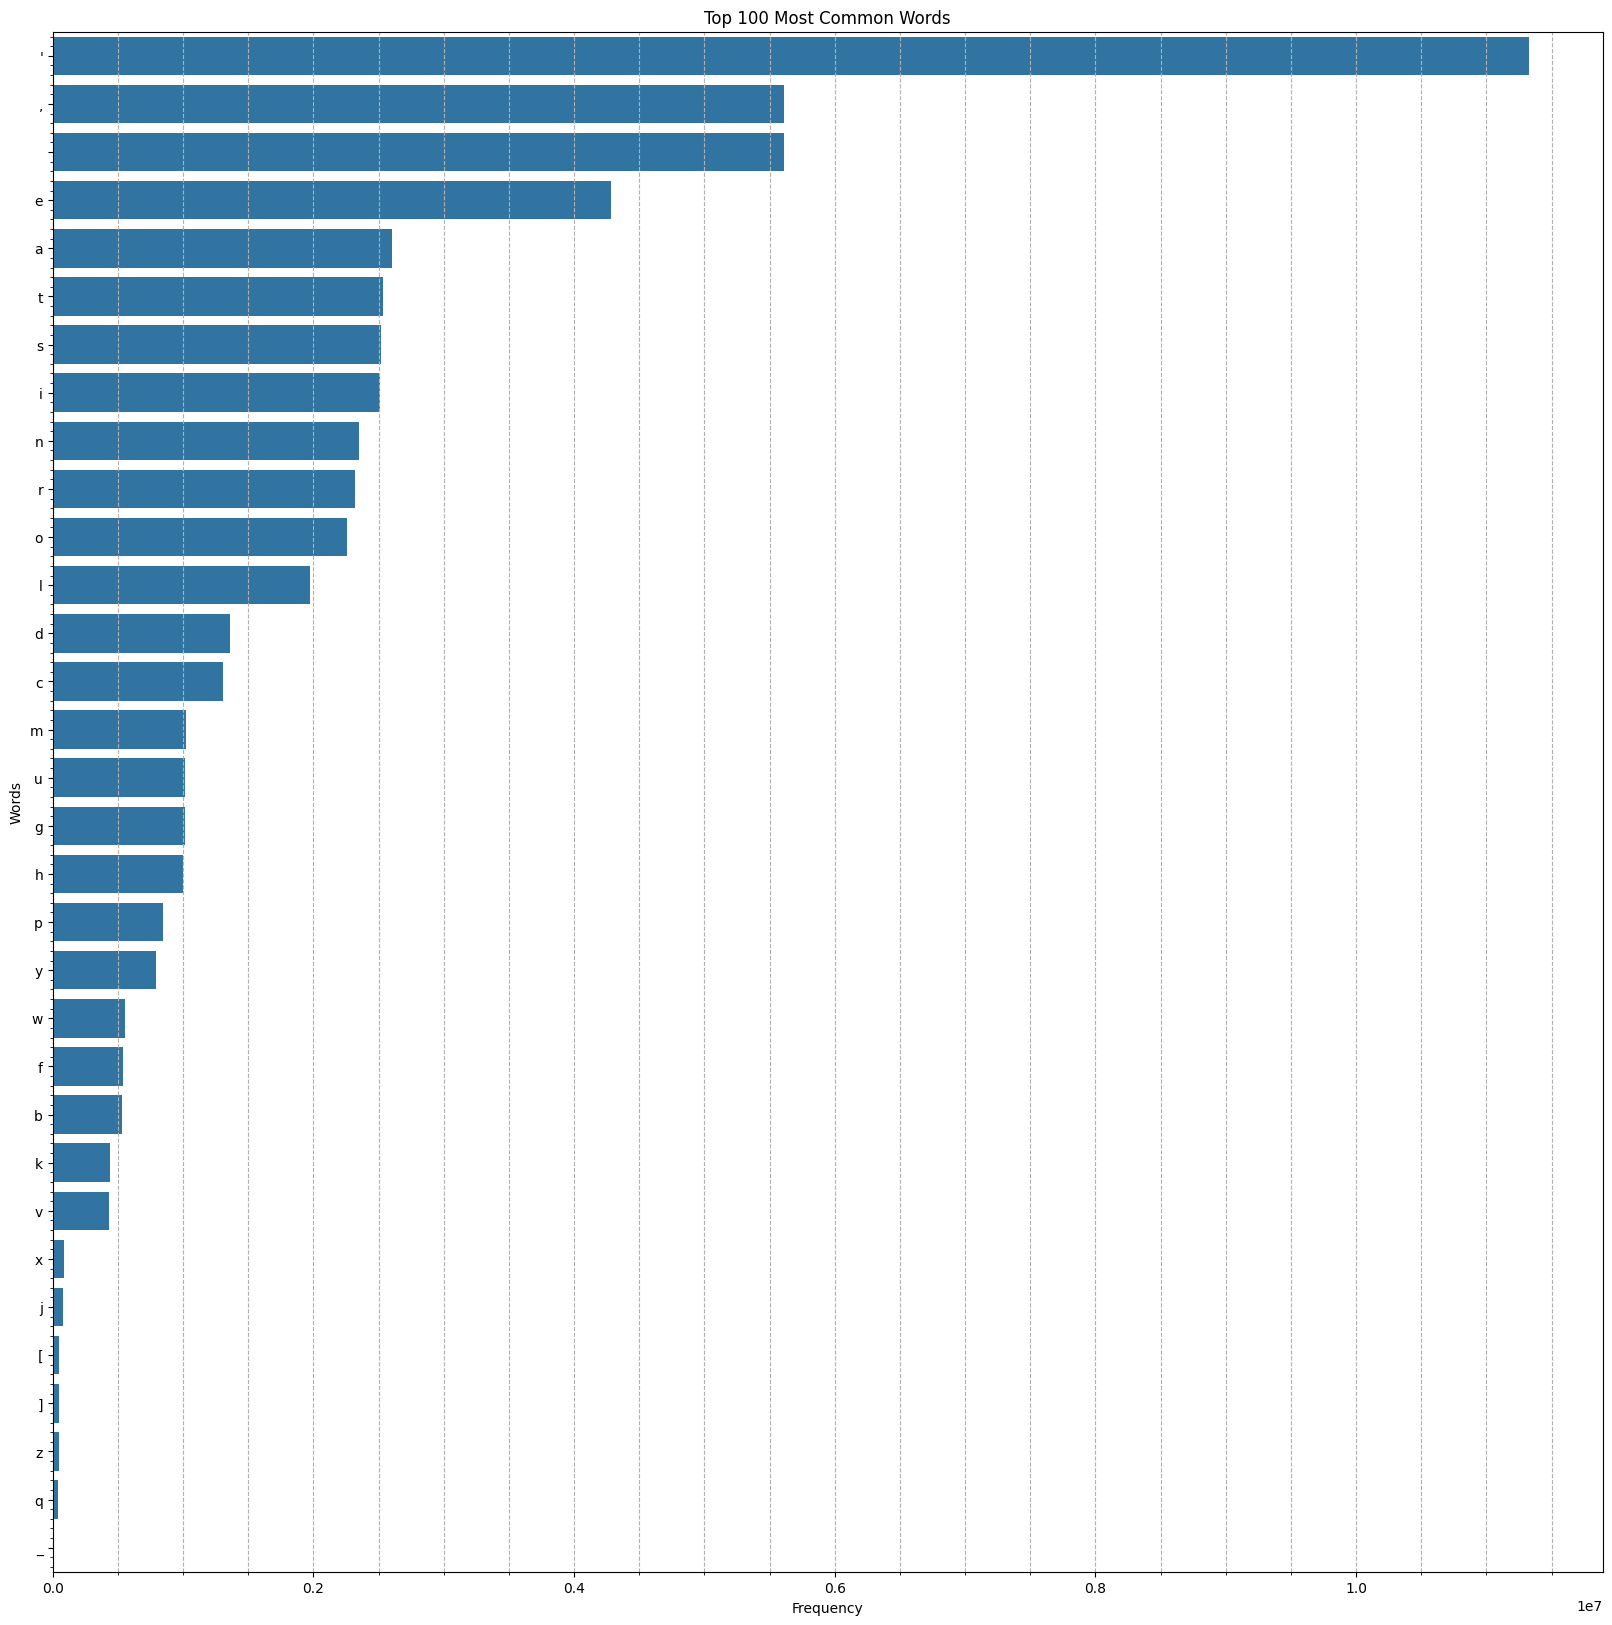

In [ ]:
# Compute word frequencies
fdist = FreqDist(words)

# Number of words to plot
n_words = 100

# Create a DataFrame for plotting
common_words_df = pd.DataFrame(
    fdist.most_common(n_words),
    columns=['Word', 'Frequency']
).sort_values('Frequency', ascending=False)

# Plot the top 100 most common words as a horizontal bar plot using seaborn
plt.figure(figsize=(20, 20))
sns.barplot(x='Frequency', y='Word', data=common_words_df)
plt.title(f"Top {n_words} Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

In [ ]:
# Separate reviews by sentiment
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']['review']
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']['review']

# Tokenize and remove stopwords
positive_tokens = [word for review in positive_reviews for word in word_tokenize(review.lower()) if word not in stop_words]
negative_tokens = [word for review in negative_reviews for word in word_tokenize(review.lower()) if word not in stop_words]

# Compute frequency distribution
pos_freq = FreqDist(positive_tokens)
neg_freq = FreqDist(negative_tokens)

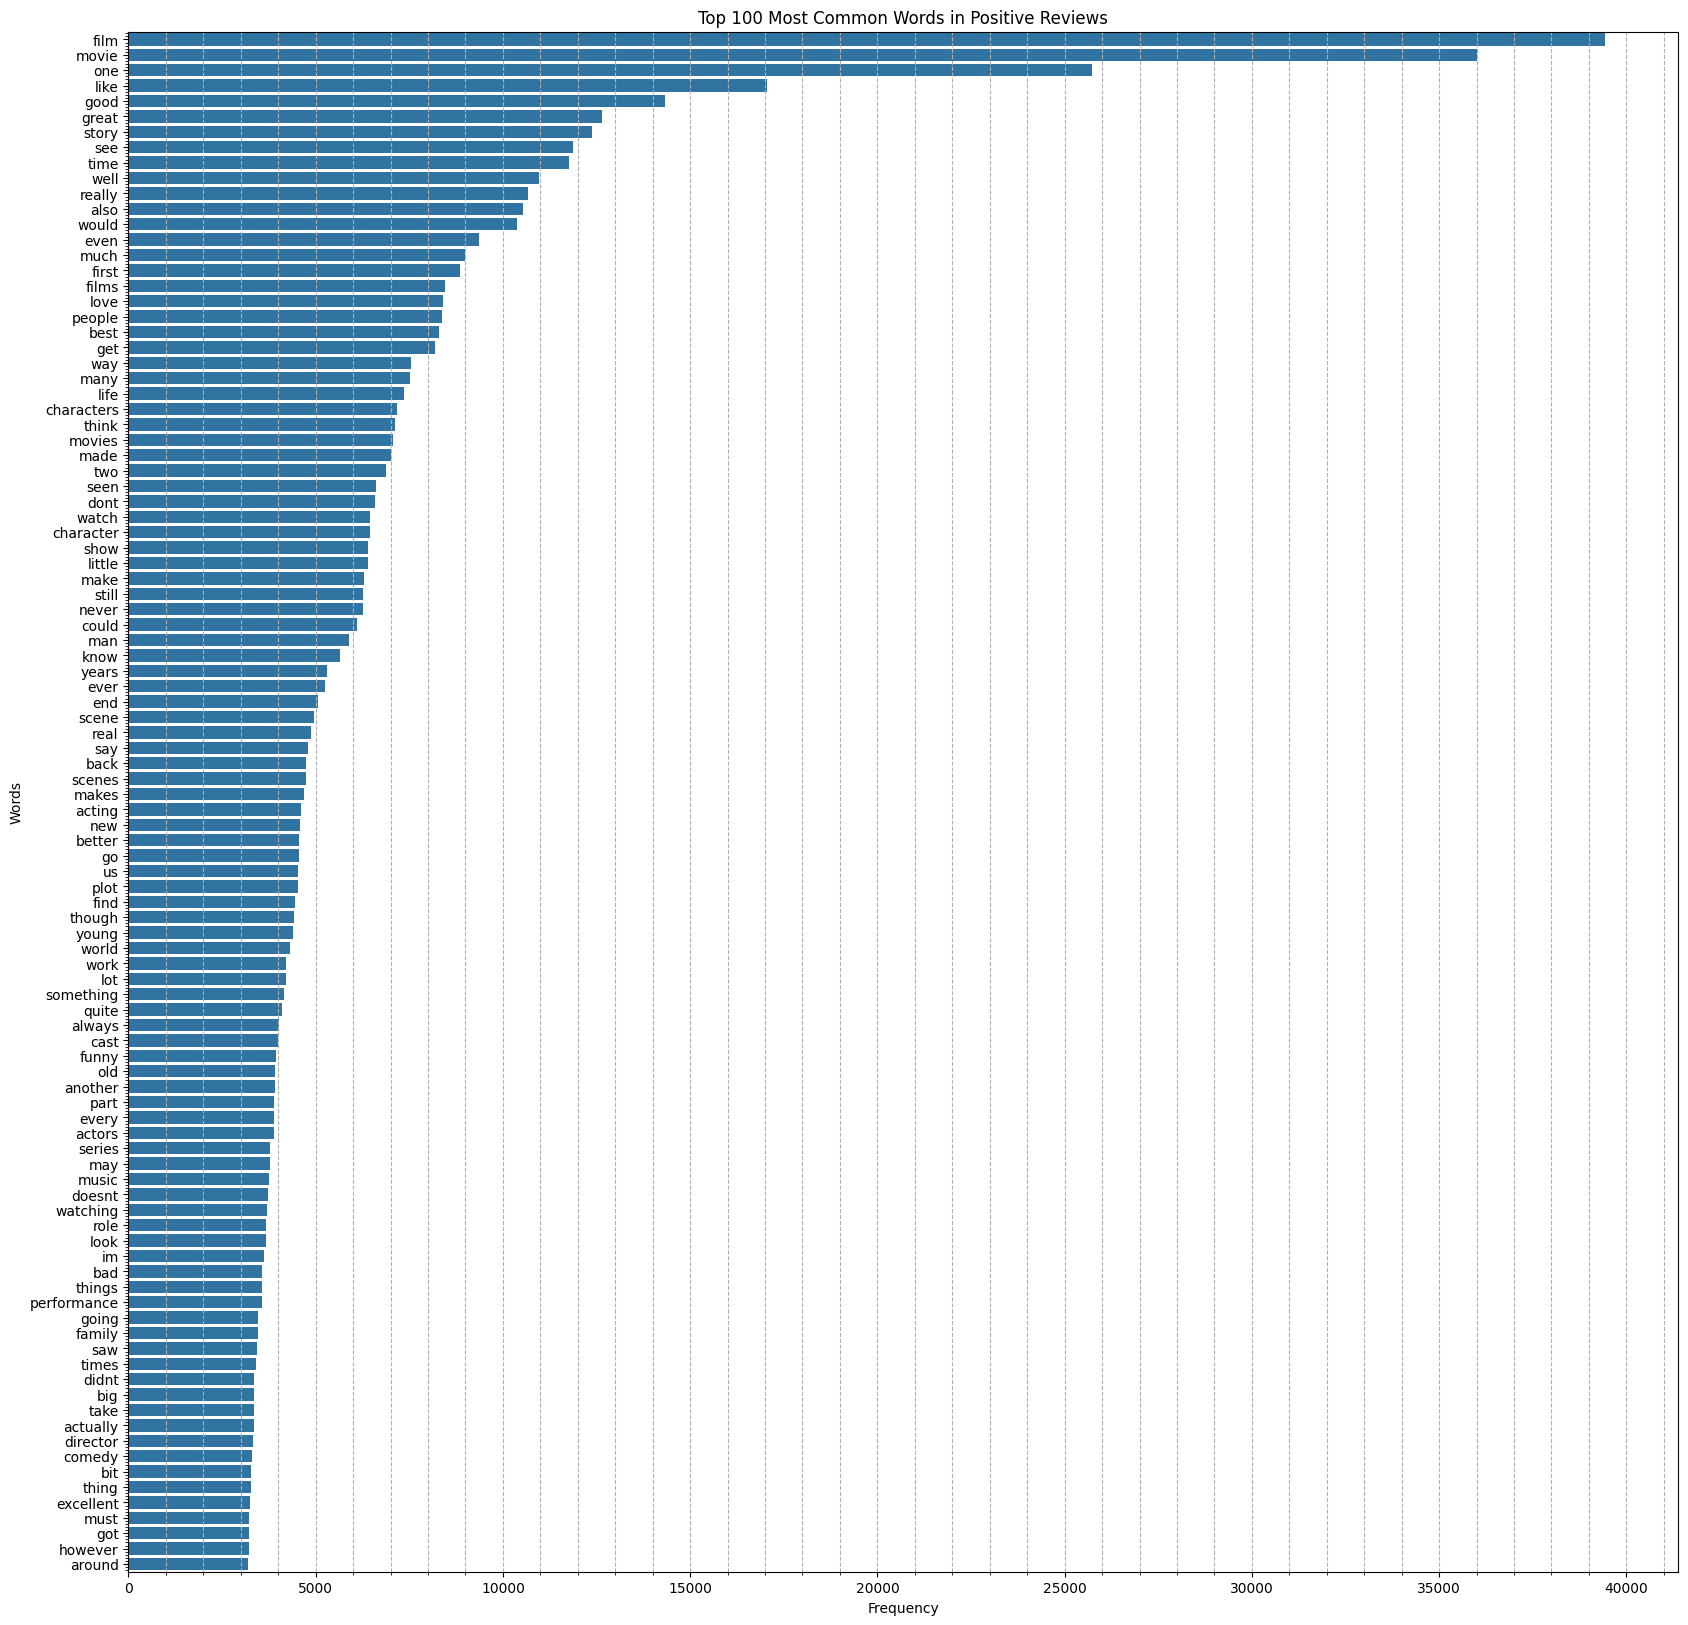

In [ ]:
# Number of words to plot
n_words = 100

# Create a DataFrame for plotting
top_words_pos_df = pd.DataFrame(
    pos_freq.most_common(n_words),
    columns=['Word', 'Frequency']
).sort_values('Frequency', ascending=False)

# Plot the top 100 most common words as a horizontal bar plot using seaborn
plt.figure(figsize=(20, 20))
sns.barplot(x='Frequency', y='Word', data=top_words_pos_df)
plt.title(f"Top {n_words} Most Common Words in Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

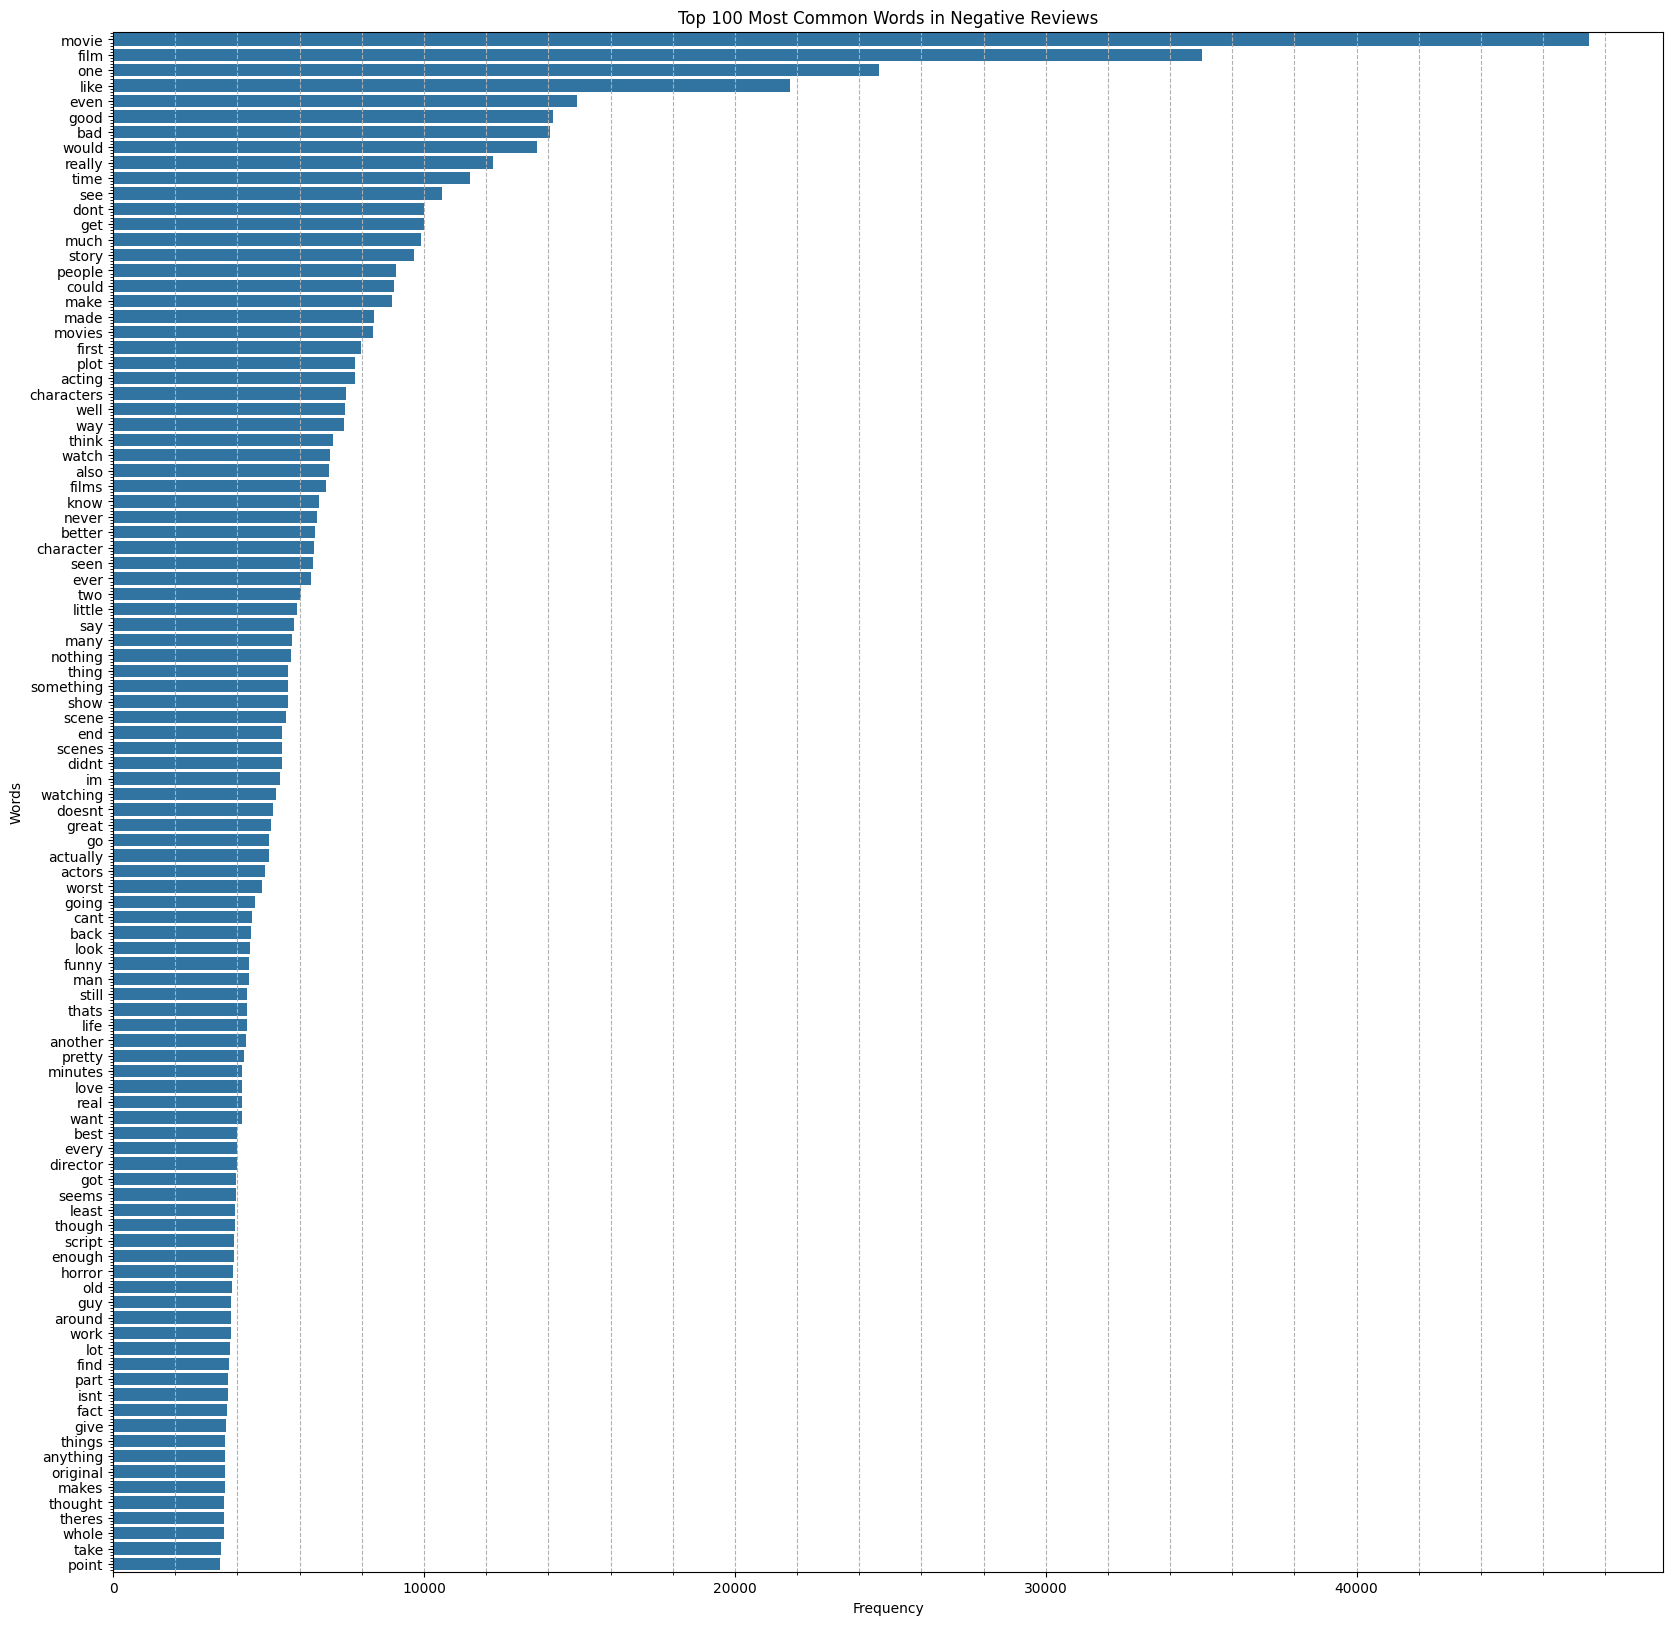

In [ ]:
# Number of words to plot
n_words = 100

# Create a DataFrame for plotting
top_words_neg_df = pd.DataFrame(
    neg_freq.most_common(n_words),
    columns=['Word', 'Frequency']
).sort_values('Frequency', ascending=False)

# Plot the top 100 most common words as a horizontal bar plot using seaborn
plt.figure(figsize=(20, 20))
sns.barplot(x='Frequency', y='Word', data=top_words_neg_df)
plt.title(f"Top {n_words} Most Common Words in Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

### Ngrams

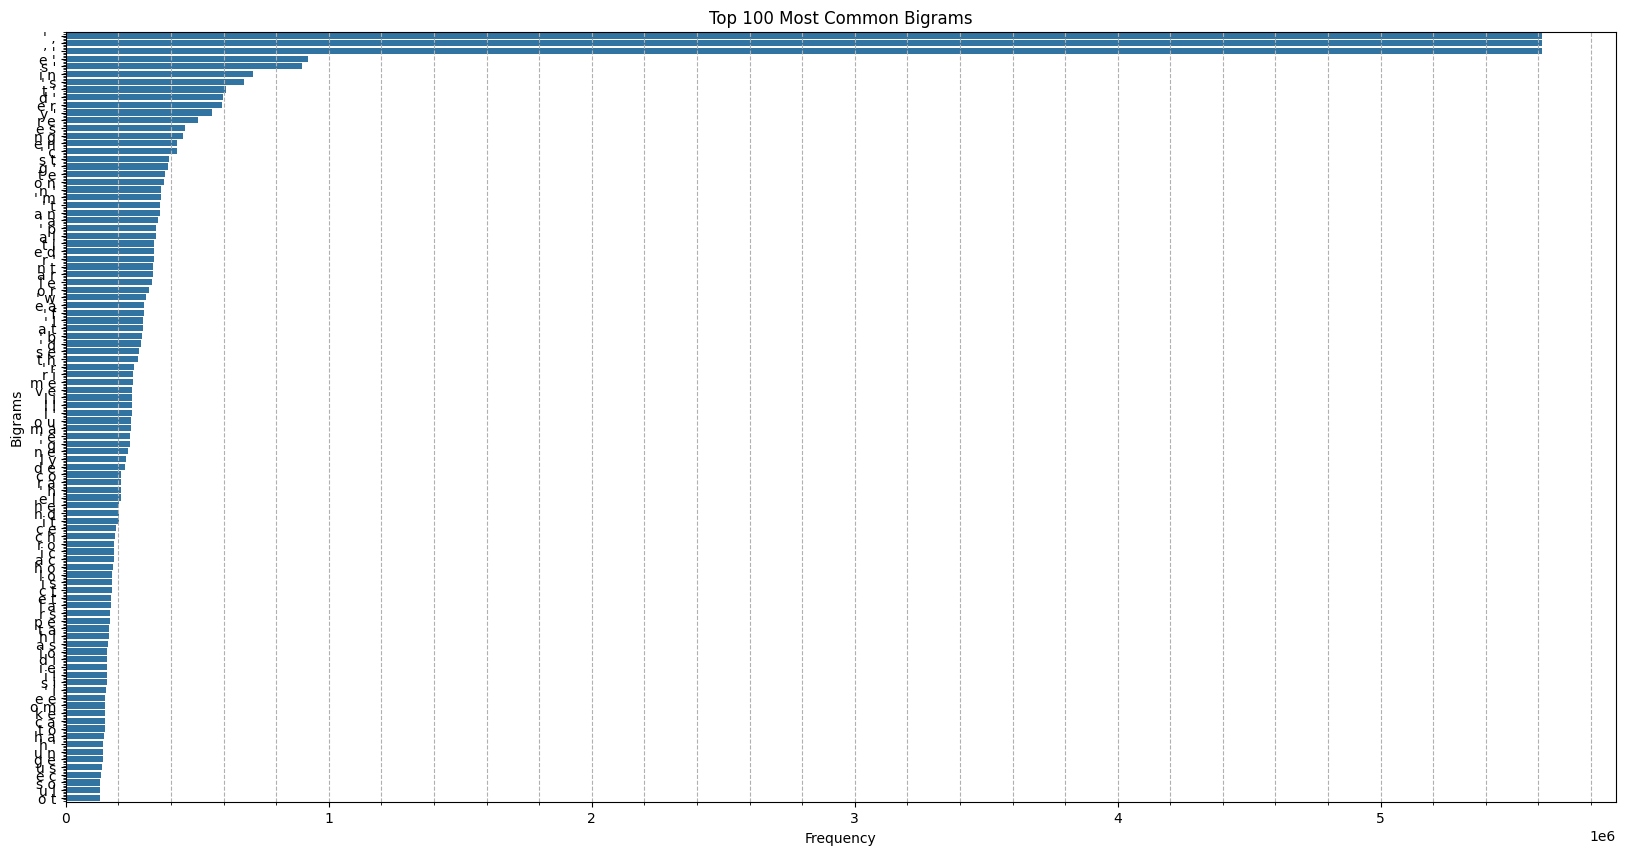

In [ ]:
# Generate bigrams from the tokenized words
bigrams_list = list(bigrams(words))

# Compute frequency distribution for bigrams
bigram_freq = FreqDist(bigrams_list)

# Number of bigrams to plot 
n_bigrams = 100

# Get the most common bigrams
most_common_bigrams = bigram_freq.most_common(n_bigrams)

# Visualize the most common bigrams
bigram_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(20, 10))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df)
plt.title(f'Top {n_bigrams} Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

In [ ]:
# Extract bigrams and trigrams
pos_bigrams = list(ngrams(positive_tokens, 2))
neg_bigrams = list(ngrams(negative_tokens, 2))

pos_trigrams = list(ngrams(positive_tokens, 3))
neg_trigrams = list(ngrams(negative_tokens, 3))

# Compute frequency
pos_bigram_freq = FreqDist(pos_bigrams)
neg_bigram_freq = FreqDist(neg_bigrams)

pos_trigram_freq = FreqDist(pos_trigrams)
neg_trigram_freq = FreqDist(neg_trigrams)

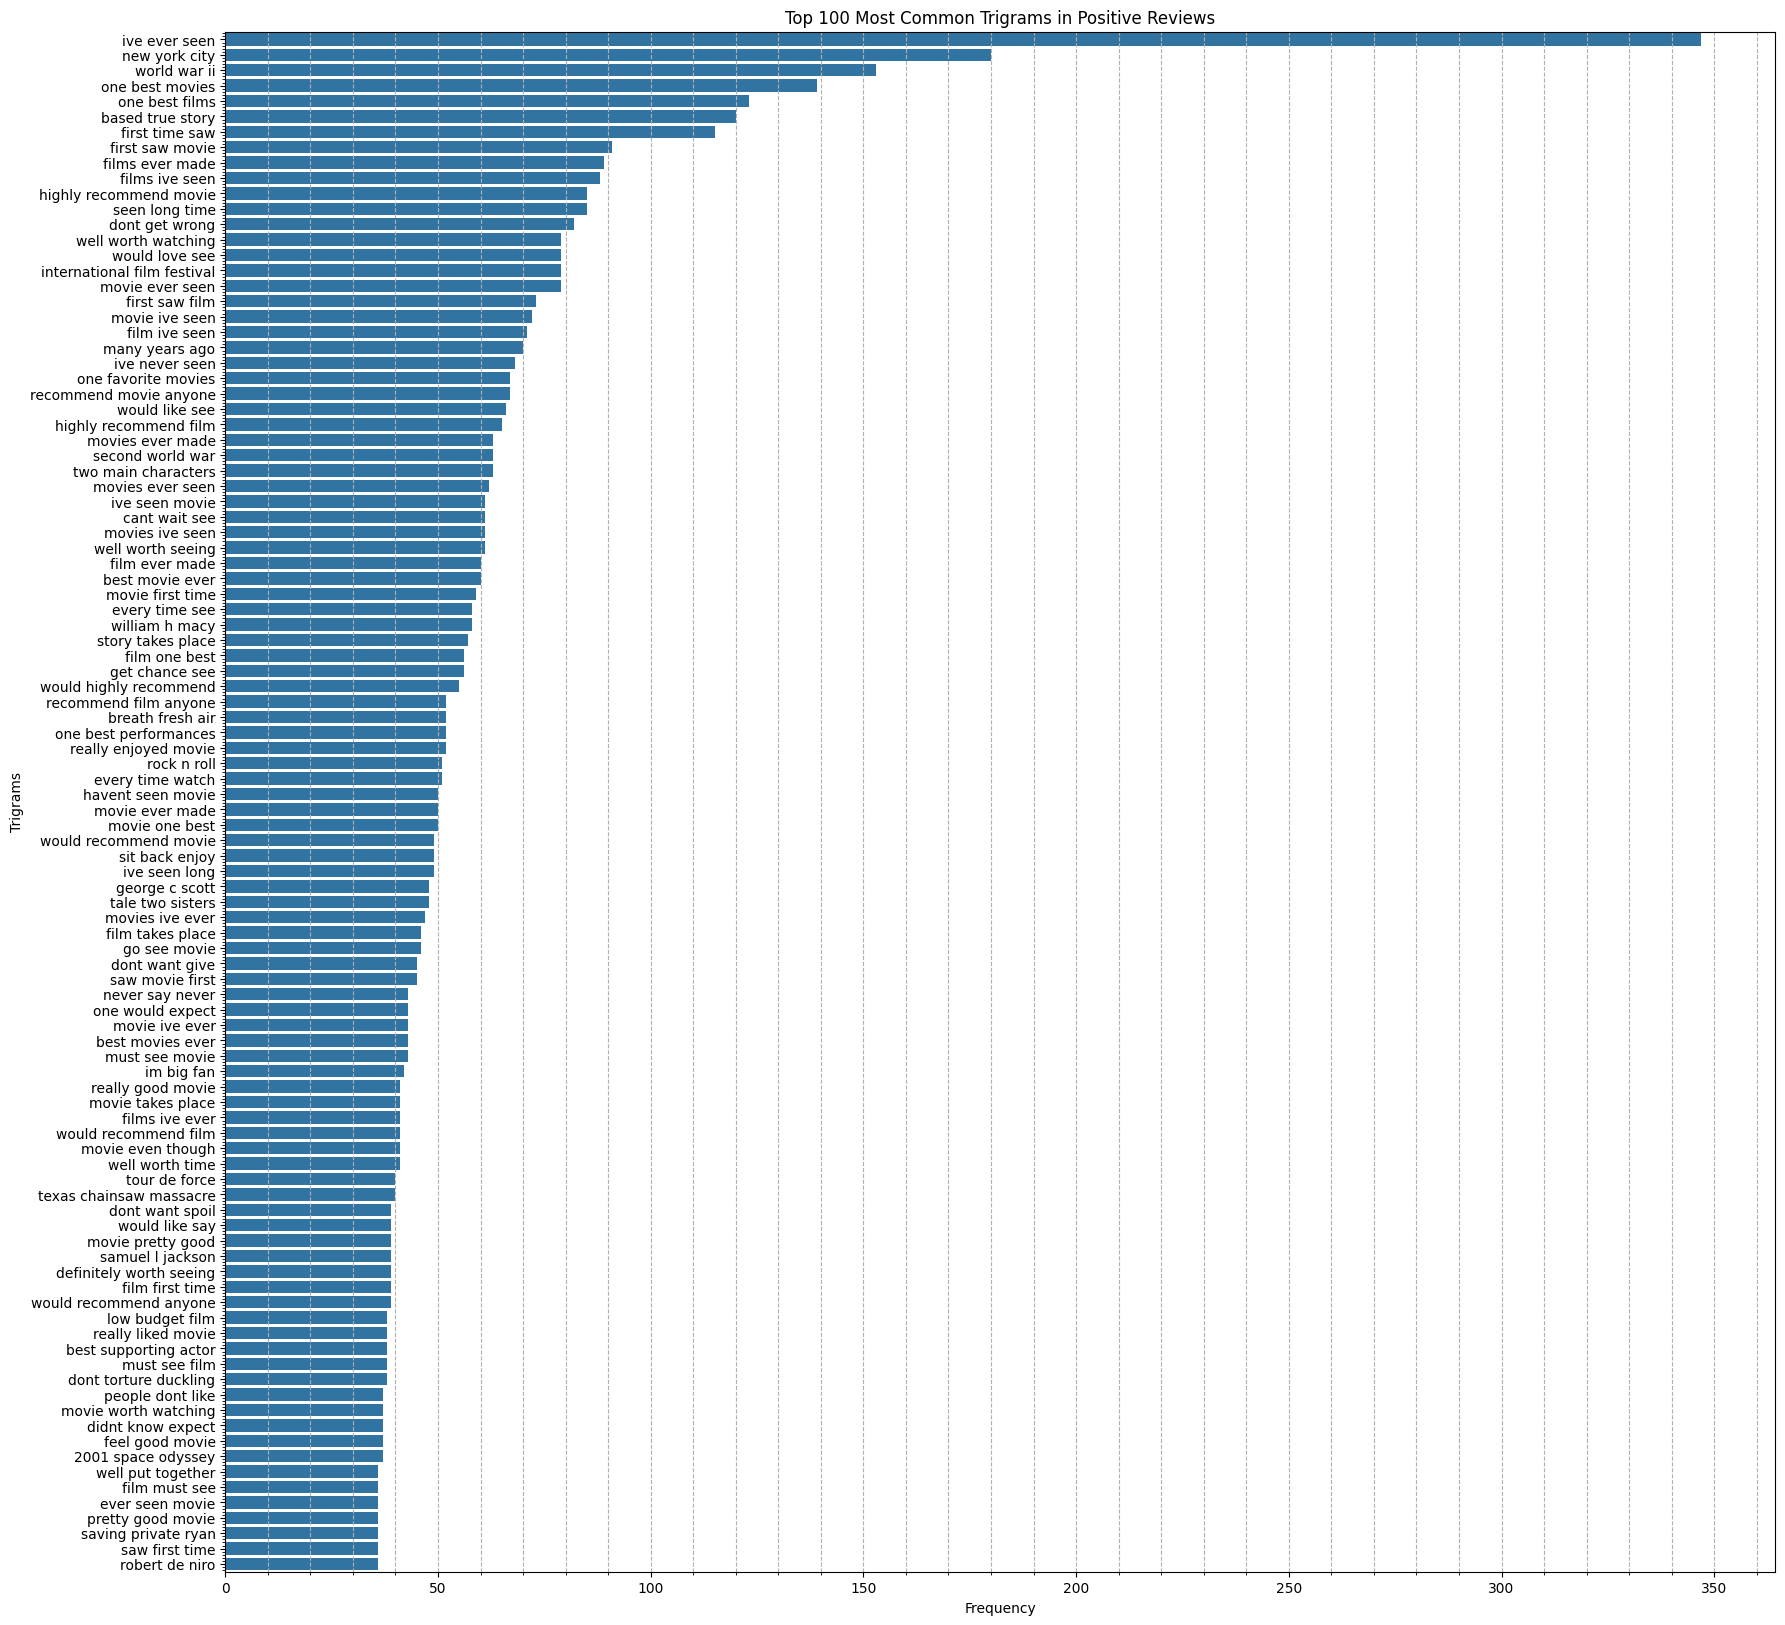

In [ ]:
# Number of trigrams to plot
n_trigrams = 100

# Get the most common positive trigrams
most_common_pos_trigrams = pos_trigram_freq.most_common(n_trigrams)

# Create a DataFrame for plotting
top_pos_trigrams_df = pd.DataFrame(
    most_common_pos_trigrams,
    columns=['Trigram', 'Frequency']
).sort_values('Frequency', ascending=False)

# Convert trigrams to strings for better readability
top_pos_trigrams_df['Trigram'] = top_pos_trigrams_df['Trigram'].apply(lambda x: ' '.join(x))

# Plot the top 100 most common positive trigrams as a horizontal bar plot using seaborn
plt.figure(figsize=(20, 20))
sns.barplot(x='Frequency', y='Trigram', data=top_pos_trigrams_df)
plt.title(f"Top {n_trigrams} Most Common Trigrams in Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

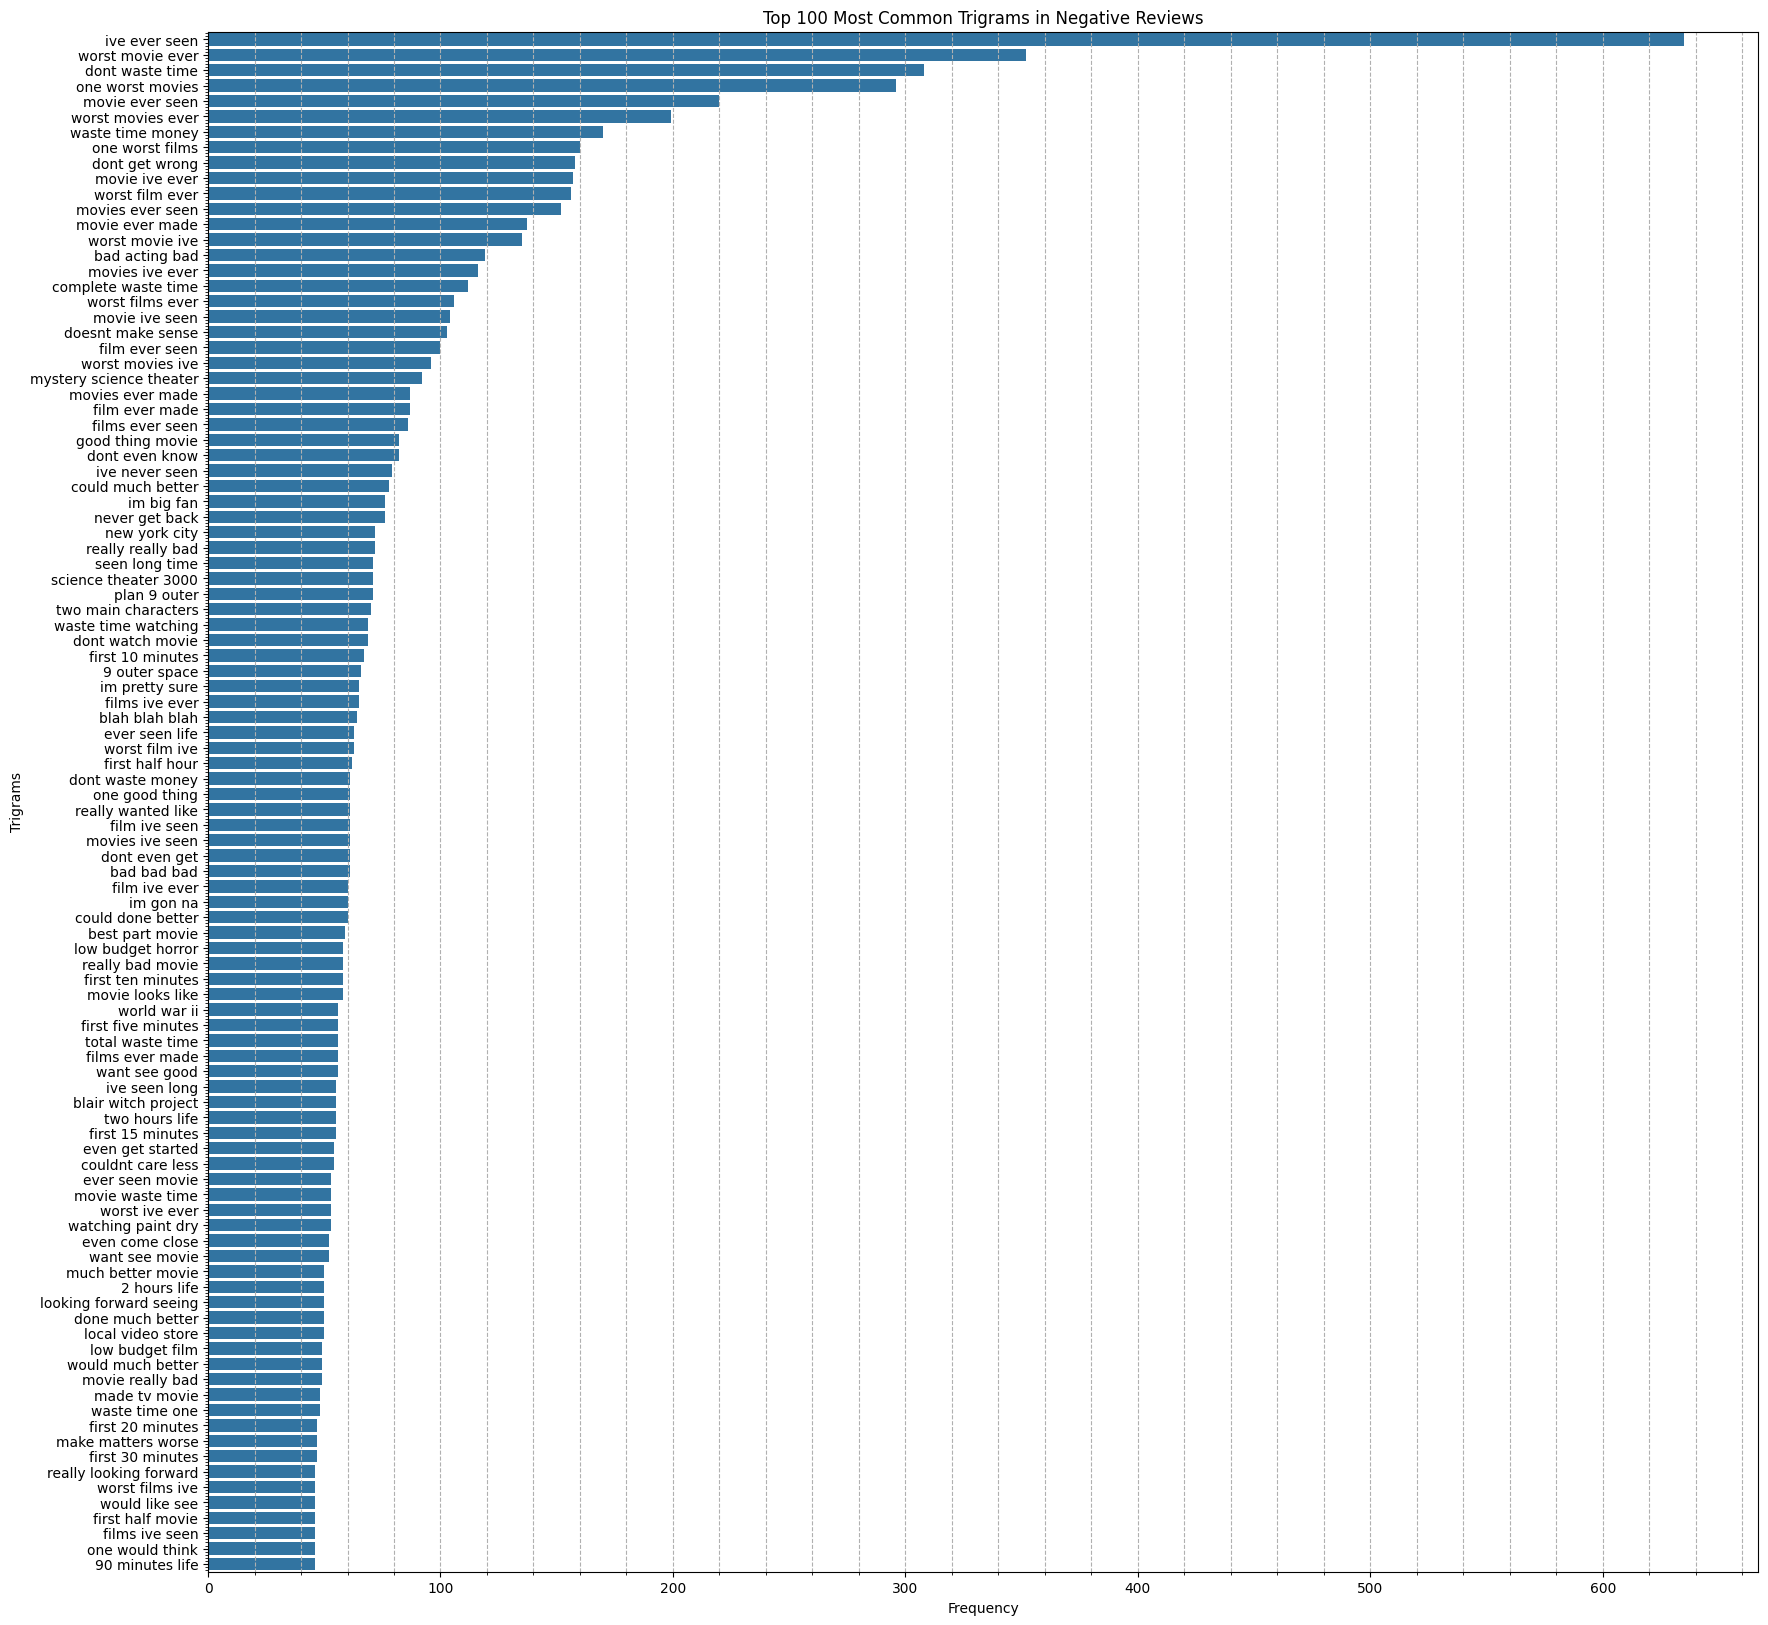

In [ ]:
# Number of trigrams to plot
n_trigrams = 100

# Get the most common negative trigrams
most_common_neg_trigrams = neg_trigram_freq.most_common(n_trigrams)

# Create a DataFrame for plotting
top_neg_trigrams_df = pd.DataFrame(
    most_common_neg_trigrams,
    columns=['Trigram', 'Frequency']
).sort_values('Frequency', ascending=False)

# Convert trigrams to strings for better readability
top_neg_trigrams_df['Trigram'] = top_neg_trigrams_df['Trigram'].apply(lambda x: ' '.join(x))

# Plot the top 100 most common negative trigrams as a horizontal bar plot using seaborn
plt.figure(figsize=(20, 20))
sns.barplot(x='Frequency', y='Trigram', data=top_neg_trigrams_df)
plt.title(f"Top {n_trigrams} Most Common Trigrams in Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

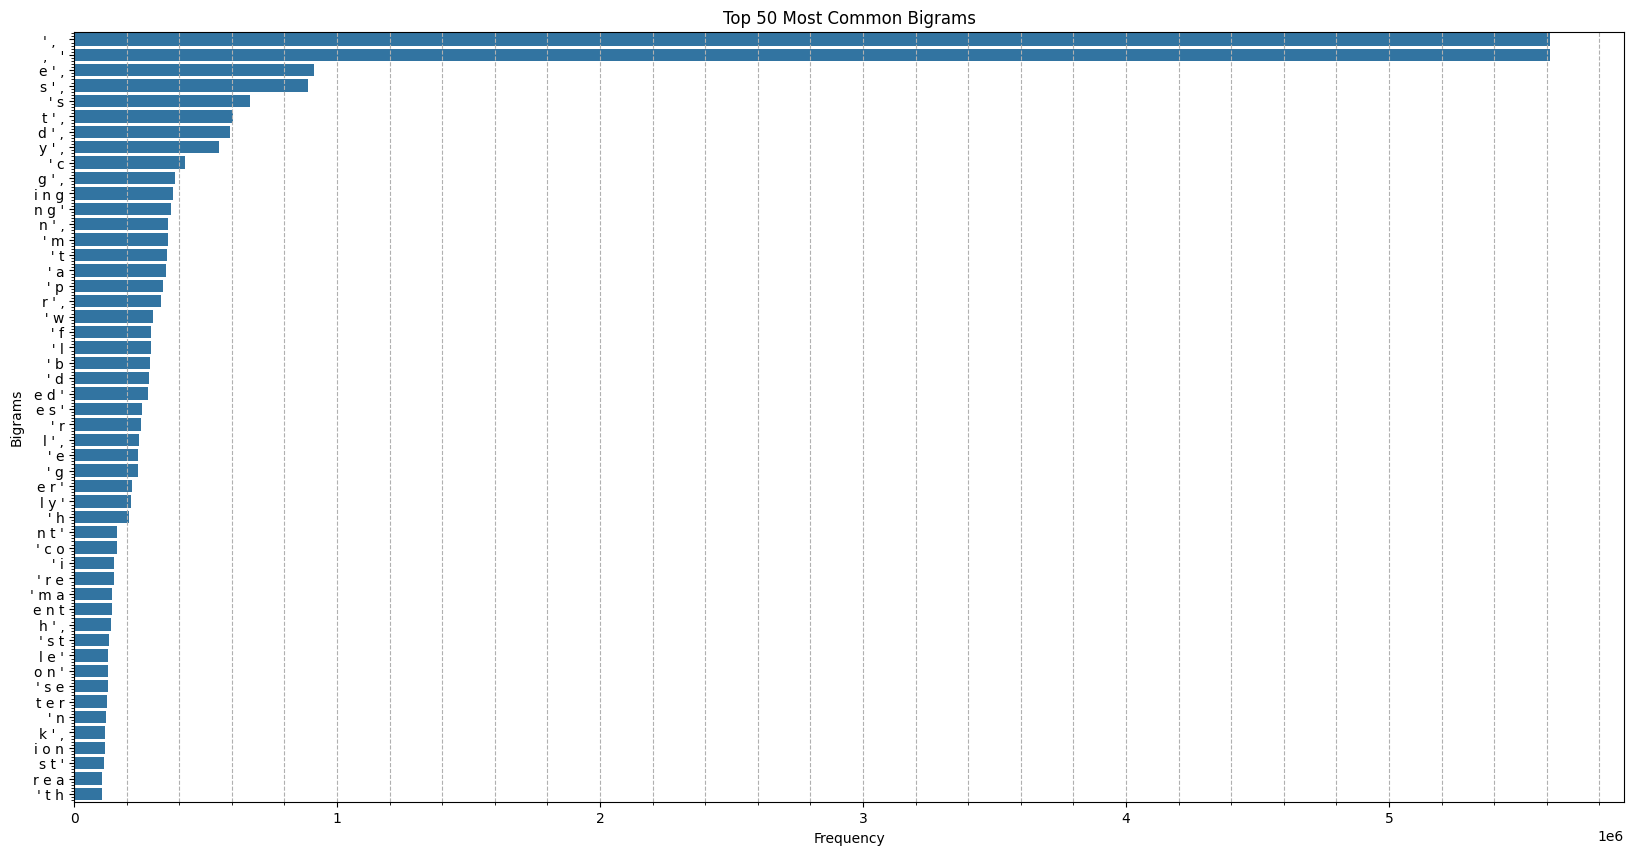

In [ ]:
# Generate trigrams from the tokenized words
trigrams_list = list(trigrams(words))

# Compute frequency distribution for trigrams
trigram_freq = FreqDist(trigrams_list)

# Number of trigrams to plot
n_trigrams = 50

# Get the most common trigrams
most_common_trigrams = trigram_freq.most_common(n_trigrams)

# Visualize the most common trigrams
trigram_df = pd.DataFrame(most_common_trigrams, columns=['Trigram', 'Frequency'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(20, 10))
sns.barplot(x='Frequency', y='Trigram', data=trigram_df)
plt.title(f'Top {n_trigrams} Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.grid(axis='x', linestyle='--', which='both')  # Add vertical gridlines for both major and minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.show()

## Wordcloud

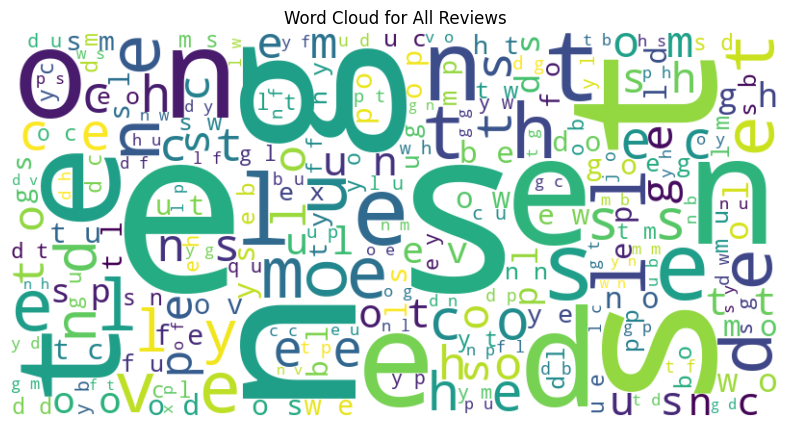

In [ ]:
# Combine all tokens into a single string
all_tokens = ' '.join([' '.join(tokens) for tokens in imdb_df['tokens']])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews')
plt.show()

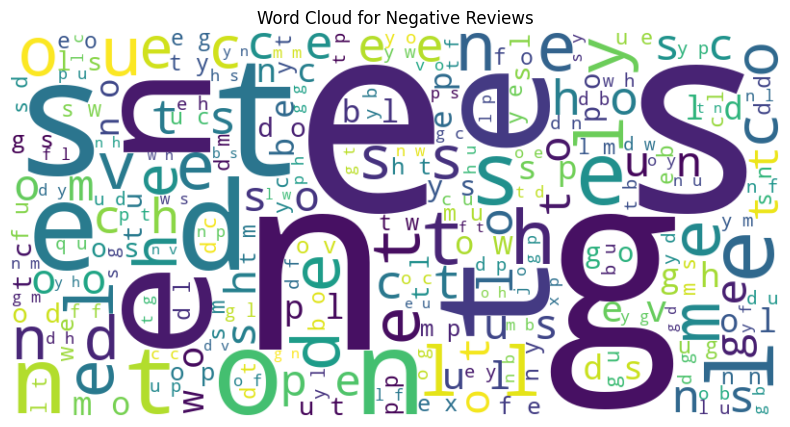

In [ ]:
# Filter the dataframe for negative reviews
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']

# Combine all tokens into a single string for negative reviews
negative_tokens = ' '.join([' '.join(tokens) for tokens in negative_reviews['tokens']])

# Create the word cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_tokens)

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

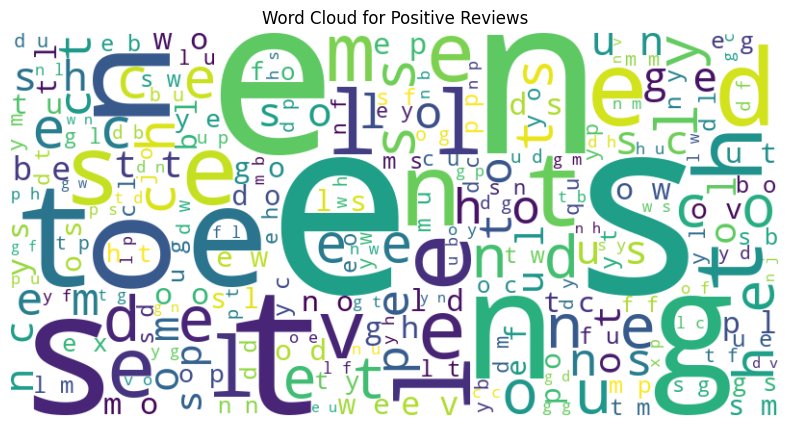

In [ ]:
# Filter the dataframe for positive reviews
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']

# Combine all tokens into a single string for positive reviews
positive_tokens = ' '.join([' '.join(tokens) for tokens in positive_reviews['tokens']])

# Create the word cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tokens)

# Plot the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

## Logistic Regression with TF-IDF vectorization

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['sentiment'], test_size=0.2, random_state=42)   

# Convert text into TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Use top 5000 words

X_train_tfidf = tfidf.fit_transform(X_train)
# Convert text into TF-IDF features for the test set
X_test_tfidf = tfidf.transform(X_test)

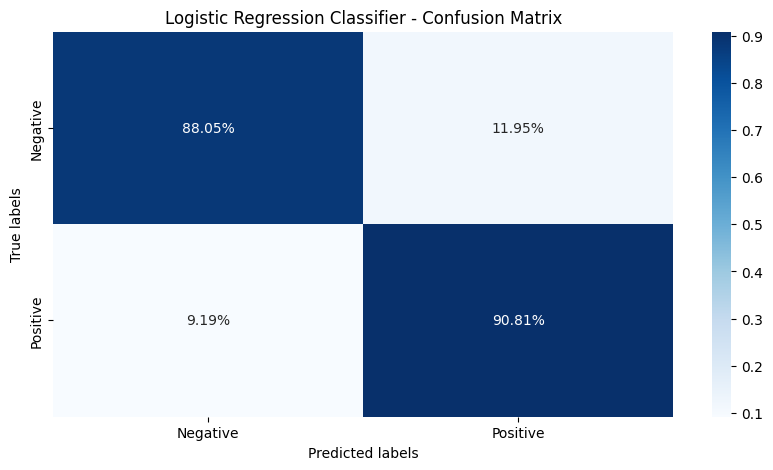

In [ ]:
# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Display the confusion matrix as proportions
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Classifier - Confusion Matrix')
plt.show()

## LDA Analysis

In [ ]:
data = imdb_df['tokens'].tolist()
# Create dictionary and corpus
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
# # Store results
# num_topics = []
# perplexity_scores = []
# coherence_scores = []

# for n_topics in range(2, 21):
#     print(f'Performing LDA for {n_topics} topics')
#     lda_model = gensim.models.LdaMulticore(
#         corpus=corpus,
#         id2word=id2word,
#         num_topics=n_topics,
#         random_state=42,
#         passes=10,
#         workers=3
#     )
    
#     num_topics.append(n_topics)

#     # Compute Perplexity
#     perplexity = lda_model.log_perplexity(corpus)
#     perplexity_scores.append(perplexity)
    
#     # Compute Coherence Score
#     coherence_model = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
#     coherence_score = coherence_model.get_coherence()
#     coherence_scores.append(coherence_score)

# # Compile results into a DataFrame
# results_df = pd.DataFrame({
#     'num_topics': num_topics,
#     'coherence': coherence_scores,
#     'perplexity': perplexity_scores
# })

Performing LDA for 2 topics
Performing LDA for 3 topics
Performing LDA for 4 topics
Performing LDA for 5 topics
Performing LDA for 6 topics
Performing LDA for 7 topics
Performing LDA for 8 topics
Performing LDA for 9 topics
Performing LDA for 10 topics
Performing LDA for 11 topics
Performing LDA for 12 topics
Performing LDA for 13 topics
Performing LDA for 14 topics
Performing LDA for 15 topics
Performing LDA for 16 topics
Performing LDA for 17 topics
Performing LDA for 18 topics
Performing LDA for 19 topics
Performing LDA for 20 topics


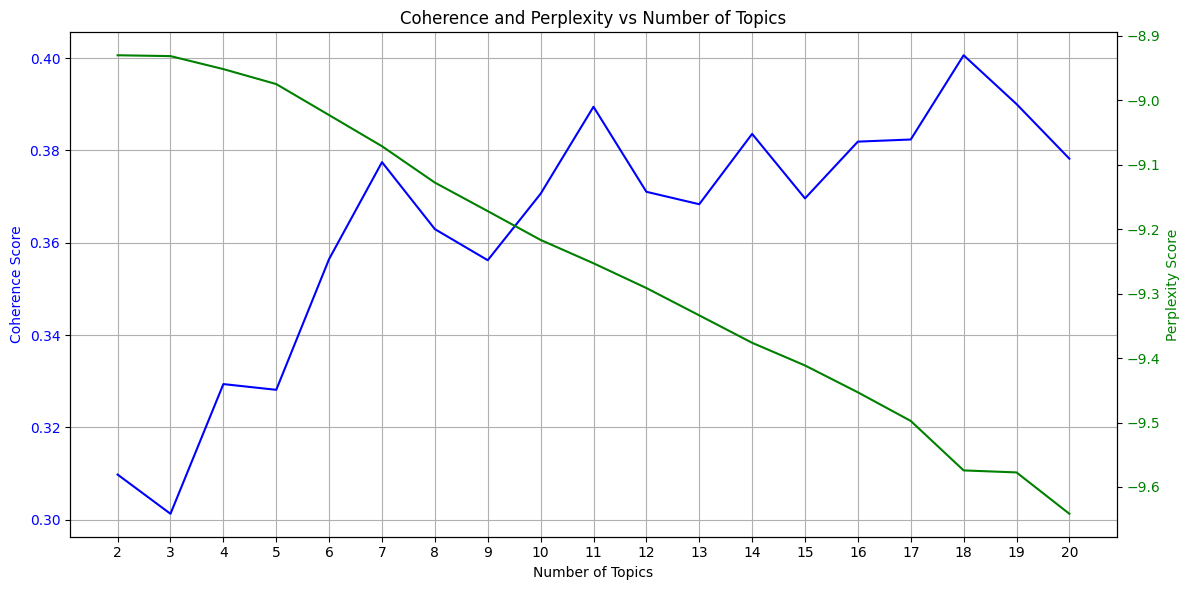

In [ ]:
# # Create a figure and a set of subplots
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot coherence scores
# sns.lineplot(x='num_topics', y='coherence', data=results_df, ax=ax1, color='blue')
# ax1.set_xlabel('Number of Topics')
# ax1.set_ylabel('Coherence Score', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_xticks(range(2, 21))

# # Create a second y-axis to plot perplexity scores
# ax2 = ax1.twinx()
# sns.lineplot(x='num_topics', y='perplexity', data=results_df, ax=ax2, color='green')
# ax2.set_ylabel('Perplexity Score', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # Add gridlines
# ax1.grid(True)

# # Add a title and show the plot
# plt.title('Coherence and Perplexity vs Number of Topics')
# fig.tight_layout()
# plt.show()

In [ ]:
# num_topics_optimal = 11

# lda_model = gensim.models.LdaMulticore(
#     corpus=corpus,
#     id2word=id2word,
#     num_topics=num_topics_optimal,
#     random_state=42,
#     passes=10,
#     workers=3
# )

In [ ]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# pyLDAvis.display(lda_display)